I’d like to kindly mention that, due to the tight time constraints with the Monday EOD deadline, I took some assistance from Chatgpt for generating explanations and resolving some errors in my code.

## Extract Functions for Transaction Actions

This cell defines helper functions to extract relevant transaction data from the raw JSON files.

- `extract_simple_actions`: Extracts structured information for actions like deposits, borrows, repays, and withdraws. Each row contains wallet address, timestamp, amount in USD, asset symbol, transaction hash, and the action type.

- `extract_liquidations`: Special handling for liquidations, which involves two roles—`liquidatee` and `liquidator`. This function generates two entries per liquidation: one for the user being liquidated and one for the liquidator.

These functions return Pandas DataFrames that will later be used for merging and analysis.


In [3]:
import json
import pandas as pd
import os

def extract_simple_actions(data, action_type):
    rows = []
    for entry in data.get(action_type, []):
        try:
            rows.append({
                "wallet_address": entry["account"]["id"],
                "timestamp": entry["timestamp"],
                "amountUSD": float(entry["amountUSD"]),
                "asset_symbol": entry["asset"]["symbol"],
                "tx_hash": entry["hash"],
                "action_type": action_type
            })
        except Exception as e:
            print(f"[{action_type}] Skipping entry due to error: {e}")
    return pd.DataFrame(rows)

def extract_liquidations(data):
    rows = []
    for entry in data.get("liquidates", []):
        try:
            base = {
                "timestamp": entry["timestamp"],
                "amountUSD": float(entry["amountUSD"]),
                "asset_symbol": entry["asset"]["symbol"],
                "tx_hash": entry["hash"]
            }
            rows.append({**base, "wallet_address": entry["liquidatee"]["id"], "action_type": "got_liquidated"})
            rows.append({**base, "wallet_address": entry["liquidator"]["id"], "action_type": "liquidator"})
        except Exception as e:
            print(f"[liquidates] Skipping entry due to error: {e}")
    return pd.DataFrame(rows)


##  Loading and Aggregating JSON Transaction Data

This cell loads and processes multiple JSON files containing Compound V2 DeFi protocol transaction data.

For each file:
- It extracts actions such as **deposits**, **borrows**, **repays**, **withdraws**, and **liquidations** using the previously defined functions.
- These extracted actions are combined into a single DataFrame.
- All DataFrames are then concatenated into a final unified dataset called `final_df`, which will be_


In [4]:
json_files = ['/content/compoundV2_transactions_ethereum_chunk_1.json',
              '/content/compoundV2_transactions_ethereum_chunk_2.json',
              '/content/compoundV2_transactions_ethereum_chunk_3.json'
]

all_dfs = []

for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)

    df_deposits = extract_simple_actions(data, "deposits")
    df_borrows = extract_simple_actions(data, "borrows")
    df_repays = extract_simple_actions(data, "repays")
    df_withdraws = extract_simple_actions(data, "withdraws")
    df_liquidates = extract_liquidations(data)

    combined = pd.concat([df_deposits, df_borrows, df_repays, df_withdraws,  df_liquidates], ignore_index=True)
    all_dfs.append(combined)



final_df = pd.concat(all_dfs, ignore_index=True)

In [5]:
final_df.head()

,wallet_address,timestamp,amountUSD,asset_symbol,tx_hash,action_type
0,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,1562192556,294.098362,DAI,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,deposits
1,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,1562192990,236.936134,DAI,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,deposits
2,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,1562193000,498.044019,DAI,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,deposits
3,0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f,1562193019,300.000000,USDC,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,deposits
4,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,1562193418,476.020148,DAI,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,deposits


In [6]:
final_df.to_csv('final_df.csv', index=False)

In [7]:
final_df.columns

Index(['wallet_address', 'timestamp', 'amountUSD', 'asset_symbol', 'tx_hash',
       'action_type'],
      dtype='object')

In [9]:
final_df.size

848844

In [10]:
print(final_df['action_type'].value_counts())

action_type
deposits          30000
borrows           30000
repays            30000
withdraws         30000
got_liquidated    10737
liquidator        10737
Name: count, dtype: int64


In [11]:
print(final_df['wallet_address'].value_counts())

wallet_address
0x586e32930ac05127de429bd566eaa2758fcbd9bc    4031
0xd911560979b78821d7b045c79e36e9cbfc2f6c6f    3172
0xf859a1ad94bcf445a406b892ef0d3082f4174088    2850
0x37acfef331e6063c8507c2a69c97b4f78c770a5a    1841
0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832    1545
                                              ... 
0x941af3ebeebe822a832159a8329e56d2f74cb1c2       1
0xabc6244ad15799b62be8278cbe42861d3956d849       1
0x33b8287511ac7f003902e83d642be4603afcd876       1
0x87f68d3c871442e32247b0584c2efd7012fbe1f7       1
0x1f9e9705a0d8cb03bf9b709907d74e8d4e729a76       1
Name: count, Length: 19525, dtype: int64


In [12]:
print(final_df['action_type'].value_counts())

action_type
deposits          30000
borrows           30000
repays            30000
withdraws         30000
got_liquidated    10737
liquidator        10737
Name: count, dtype: int64


In [13]:
df=final_df
df.size

848844

## Data Cleaning and Preprocessing

This cell performs basic preprocessing on the combined transaction DataFrame:

- Converts Unix timestamps to human-readable datetime format.
- Ensures `amountUSD` is stored as a numeric (float), coercing invalid values to NaN.
- Normalizes all wallet addresses to lowercase for consistency.
- Checks and prints the count of missing values in each column.
- Drops any duplicate records that may exist.
- Displays the first few rows of the cleaned dataset as a sanity check.


In [14]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Ensure amountUSD is float
df['amountUSD'] = pd.to_numeric(df['amountUSD'], errors='coerce')

# Normalize wallet addresses to lowercase
df['wallet_address'] = df['wallet_address'].str.lower()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop duplicates if any
df = df.drop_duplicates()

# Display sample
print(df.head())

<ipython-input-14-e5ad23e0aeae>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


Missing values per column:
wallet_address    0
timestamp         0
amountUSD         0
asset_symbol      0
tx_hash           0
action_type       0
dtype: int64
                               wallet_address           timestamp   amountUSD  \
0  0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44 2019-07-03 22:22:36  294.098362   
1  0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44 2019-07-03 22:29:50  236.936134   
2  0x3eab4037a2e7f4d4d0946c091fe135838221f2b6 2019-07-03 22:30:00  498.044019   
3  0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f 2019-07-03 22:30:19  300.000000   
4  0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44 2019-07-03 22:36:58  476.020148   

  asset_symbol                                            tx_hash action_type  
0          DAI  0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...    deposits  
1          DAI  0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...    deposits  
2          DAI  0xe611412cb9164421a95070e96b041ee12fca19a04aaa...    deposits  
3         USDC  0xcb7f5145eb6779c

In [15]:
df.size

848358

In [16]:
df.columns

Index(['wallet_address', 'timestamp', 'amountUSD', 'asset_symbol', 'tx_hash',
       'action_type'],
      dtype='object')

## Feature Engineering: Wallet-Level Aggregation

This section creates aggregate features for each wallet by summarizing its on-chain activity:

- Counts the number of transactions of each `action_type` (e.g., deposits, borrows).
- Sums the total USD value transacted per `action_type`.
- Computes general wallet-level features like total number of transactions, total transacted amount, number of unique assets interacted with, and the time range between the first and last transaction.
- Calculates the active lifespan of each wallet in days.
- Merges all the computed features into a single DataFrame (`final_wallet_df`) for further modeling.


In [17]:
# Count of each action type per wallet
action_counts = df.pivot_table(index='wallet_address',
                               columns='action_type',
                               values='tx_hash',
                               aggfunc='count',
                               fill_value=0)

# Total amountUSD per action type
action_amounts = df.pivot_table(index='wallet_address',
                                columns='action_type',
                                values='amountUSD',
                                aggfunc='sum',
                                fill_value=0)

# General wallet-level aggregates
wallet_agg = df.groupby('wallet_address').agg(
    total_txns=('tx_hash', 'count'),
    total_amount_usd=('amountUSD', 'sum'),
    num_unique_assets=('asset_symbol', 'nunique'),
    first_txn=('timestamp', 'min'),
    last_txn=('timestamp', 'max')
)

# Calculate activity duration in days
wallet_agg['activity_days'] = (wallet_agg['last_txn'] - wallet_agg['first_txn']).dt.days

# Merge all features into a final wallet-level feature dataframe
final_wallet_df = wallet_agg.join(action_counts).join(action_amounts, rsuffix='_usd')

# Reset index for modeling
final_wallet_df = final_wallet_df.reset_index()


In [18]:
final_wallet_df.head()

,wallet_address,total_txns,total_amount_usd,num_unique_assets,first_txn,last_txn,activity_days,borrows,deposits,got_liquidated,liquidator,repays,withdraws,borrows_usd,deposits_usd,got_liquidated_usd,liquidator_usd,repays_usd,withdraws_usd
0,0x0000000038355af6ffd5328a16cfd2170e59f39c,4,2224.528455,2,2023-11-15 20:11:59,2023-12-25 20:54:47,40,0,0,0,4,0,0,0.00,0.0,0.0,2224.528455,0.000000,0.000000
1,0x000000005bcf85aad6ed1d32db5490deddfc97f9,22,10582.470939,6,2023-12-11 12:14:59,2024-07-29 02:57:35,230,0,0,0,22,0,0,0.00,0.0,0.0,10582.470939,0.000000,0.000000
2,0x00000000af5a61acaf76190794e3fdf1289288a1,97,133020.456474,5,2019-08-14 17:21:40,2019-12-25 06:34:40,132,0,0,0,0,24,73,0.00,0.0,0.0,0.000000,50724.344572,82296.111902
3,0x00000000b1786c9698c160d78232c78d6f6474fe,30,29475.524013,5,2020-02-12 20:48:55,2020-06-02 14:59:25,110,0,0,0,0,30,0,0.00,0.0,0.0,0.000000,29475.524013,0.000000
4,0x0000000484f2217f1a64eb6d24b5cee446faeae5,17,438551.113244,1,2020-06-15 20:42:54,2020-06-22 16:46:12,6,9,0,0,0,8,0,219047.98,0.0,0.0,0.000000,219503.133244,0.000000


In [19]:
final_wallet_df.tail()

,wallet_address,total_txns,total_amount_usd,num_unique_assets,first_txn,last_txn,activity_days,borrows,deposits,got_liquidated,liquidator,repays,withdraws,borrows_usd,deposits_usd,got_liquidated_usd,liquidator_usd,repays_usd,withdraws_usd
19520,0xfff801e0bf28c9582420eeec66830c69c5670159,178,385457.162710,2,2019-07-26 14:01:11,2019-08-27 23:31:00,32,0,71,0,0,0,107,0.000000,222105.880271,0.0,0.0,0.000000,163351.282439
19521,0xfff95dea424c0d7a25471982610a2485f302fb54,2,27.226509,1,2019-07-24 03:21:59,2019-08-27 05:00:11,34,0,2,0,0,0,0,0.000000,27.226509,0.0,0.0,0.000000,0.000000
19522,0xfffa404fbfe29adae17d7900b3740367a1247fbb,1,9706.407466,1,2019-08-21 21:28:30,2019-08-21 21:28:30,0,0,1,0,0,0,0,0.000000,9706.407466,0.0,0.0,0.000000,0.000000
19523,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,3,1214.299347,3,2019-08-30 10:36:17,2020-01-29 18:12:14,152,0,2,0,0,1,0,0.000000,935.470970,0.0,0.0,278.828377,0.000000
19524,0xffffa57756e1c19c1e0026487559982e721cffff,10,34589.181358,2,2020-06-16 22:05:47,2020-06-22 21:24:18,5,3,0,0,0,7,0,9210.787994,0.000000,0.0,0.0,25378.393364,0.000000


In [20]:
final_wallet_df.size

370975

In [21]:
final_wallet_df.columns

Index(['wallet_address', 'total_txns', 'total_amount_usd', 'num_unique_assets',
       'first_txn', 'last_txn', 'activity_days', 'borrows', 'deposits',
       'got_liquidated', 'liquidator', 'repays', 'withdraws', 'borrows_usd',
       'deposits_usd', 'got_liquidated_usd', 'liquidator_usd', 'repays_usd',
       'withdraws_usd'],
      dtype='object')

In [24]:
df=final_wallet_df

## Advanced Feature Engineering: Behavioral Ratios and Time Features

In this section, we enhance the wallet feature set by introducing several derived metrics:

- **Financial Behavior Ratios**: Computed ratios that capture wallet behavior such as:
  - `withdraw_deposit_ratio`: Measures how much was withdrawn compared to deposits.
  - `liquidation_borrow_ratio`: Indicates riskiness by comparing liquidations to borrows.
  - `liquidation_txn_ratio`: Proportion of transactions that resulted in liquidations.
  - `deposit_borrow_ratio`: Reflects the balance between deposits and borrow activity.

- **Temporal Features**:
  - Converts Unix timestamps to datetime.
  - Calculates `lifespan_days`: total span between the first and last transaction.
  - Computes `active_days_ratio`: proportion of days the wallet was active during its lifespan.

These features provide insight into financial behavior and consistency of wallet activity, which are critical for unsupervised profiling or credit scoring.


In [25]:
import numpy as np


def safe_div(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0

# Ratios
df["withdraw_deposit_ratio"] = df.apply(lambda x: safe_div(x["withdraws_usd"], x["deposits_usd"]), axis=1)
df["liquidation_borrow_ratio"] = df.apply(lambda x: safe_div(x["got_liquidated_usd"], x["borrows_usd"]), axis=1)
df["liquidation_txn_ratio"] = df.apply(lambda x: safe_div(x["got_liquidated"], x["total_txns"]), axis=1)
df["deposit_borrow_ratio"] = df.apply(lambda x: safe_div(x["deposits_usd"], x["borrows_usd"]), axis=1)

# Timestamos
df["first_txn"] = pd.to_datetime(df["first_txn"], unit='s')
df["last_txn"] = pd.to_datetime(df["last_txn"], unit='s')
df["lifespan_days"] = (df["last_txn"] - df["first_txn"]).dt.total_seconds() / 86400
df["active_days_ratio"] = df.apply(lambda x: safe_div(x["activity_days"], x["lifespan_days"]), axis=1)

df.to_csv("final_dataset.csv", index=False)


In [26]:
df.head()

,wallet_address,total_txns,total_amount_usd,num_unique_assets,first_txn,last_txn,activity_days,borrows,deposits,got_liquidated,...,liquidator_usd,repays_usd,withdraws_usd,repayment_ratio,withdraw_deposit_ratio,liquidation_borrow_ratio,liquidation_txn_ratio,deposit_borrow_ratio,lifespan_days,active_days_ratio
0,0x0000000038355af6ffd5328a16cfd2170e59f39c,4,2224.528455,2,2023-11-15 20:11:59,2023-12-25 20:54:47,40,0,0,0,...,2224.528455,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,40.029722,0.999257
1,0x000000005bcf85aad6ed1d32db5490deddfc97f9,22,10582.470939,6,2023-12-11 12:14:59,2024-07-29 02:57:35,230,0,0,0,...,10582.470939,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,230.612917,0.997342
2,0x00000000af5a61acaf76190794e3fdf1289288a1,97,133020.456474,5,2019-08-14 17:21:40,2019-12-25 06:34:40,132,0,0,0,...,0.000000,50724.344572,82296.111902,5.072434e+10,0.0,0.0,0.0,0.0,132.550694,0.995845
3,0x00000000b1786c9698c160d78232c78d6f6474fe,30,29475.524013,5,2020-02-12 20:48:55,2020-06-02 14:59:25,110,0,0,0,...,0.000000,29475.524013,0.000000,2.947552e+10,0.0,0.0,0.0,0.0,110.757292,0.993163
4,0x0000000484f2217f1a64eb6d24b5cee446faeae5,17,438551.113244,1,2020-06-15 20:42:54,2020-06-22 16:46:12,6,9,0,0,...,0.000000,219503.133244,0.000000,1.002078e+00,0.0,0.0,0.0,0.0,6.835625,0.877754


In [27]:
df.size

507650

In [28]:
df.columns

Index(['wallet_address', 'total_txns', 'total_amount_usd', 'num_unique_assets',
       'first_txn', 'last_txn', 'activity_days', 'borrows', 'deposits',
       'got_liquidated', 'liquidator', 'repays', 'withdraws', 'borrows_usd',
       'deposits_usd', 'got_liquidated_usd', 'liquidator_usd', 'repays_usd',
       'withdraws_usd', 'repayment_ratio', 'withdraw_deposit_ratio',
       'liquidation_borrow_ratio', 'liquidation_txn_ratio',
       'deposit_borrow_ratio', 'lifespan_days', 'active_days_ratio'],
      dtype='object')

## Data Cleaning and Exploratory Data Analysis (EDA)

This section focuses on loading the finalized feature dataset and performing initial exploration:

- **Data Loading & Type Handling**:
  - Reads the processed CSV with parsed date columns.
  - Ensures numeric columns are properly typed and handles missing values by dropping incomplete rows.

- **Basic Statistical Overview**:
  - Provides structural and descriptive statistics to understand data distribution and range.

- **Insightful Analyses**:
  - Displays the top 10 wallets ranked by `total_amount_usd` transacted, highlighting high-volume actors.
  - Visualizes the distribution of total transacted USD with a histogram (log-scaled to reduce skew).
  - Uses a scatter plot to analyze the relationship between `repayment_ratio` and `deposit_borrow_ratio`, revealing potential behavioral patterns between wallet users.


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("final_dataset.csv", parse_dates=["first_txn", "last_txn"])

numeric_columns = df.columns.drop(["wallet_address", "first_txn", "last_txn"])
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19525 entries, 0 to 19524
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   wallet_address            19525 non-null  object        
 1   total_txns                19525 non-null  int64         
 2   total_amount_usd          19525 non-null  float64       
 3   num_unique_assets         19525 non-null  int64         
 4   first_txn                 19525 non-null  datetime64[ns]
 5   last_txn                  19525 non-null  datetime64[ns]
 6   activity_days             19525 non-null  int64         
 7   borrows                   19525 non-null  int64         
 8   deposits                  19525 non-null  int64         
 9   got_liquidated            19525 non-null  int64         
 10  liquidator                19525 non-null  int64         
 11  repays                    19525 non-null  int64         
 12  withdraws         

In [83]:
print(df.describe())

         total_txns  total_amount_usd  num_unique_assets  \
count  19525.000000      1.952500e+04       19525.000000   
mean       7.241639      1.468874e+05           1.437029   
min        1.000000      0.000000e+00           1.000000   
25%        1.000000      3.494800e+01           1.000000   
50%        2.000000      4.191014e+02           1.000000   
75%        5.000000      6.112059e+03           2.000000   
max     4031.000000      1.197311e+08          15.000000   
std       52.201969      2.072340e+06           0.906786   

                           first_txn                       last_txn  \
count                          19525                          19525   
mean   2020-03-03 18:26:53.242150912  2020-05-15 16:16:03.089116416   
min              2019-07-03 22:22:36            2019-07-03 22:49:54   
25%              2019-08-05 17:38:44            2019-08-29 01:11:21   
50%              2019-09-24 19:13:35            2019-11-07 00:50:44   
75%              2020-04-03 00:08

In [84]:
top_wallets = df.sort_values(by="total_amount_usd", ascending=False).head(10)
print("Top 10 wallets by total amount in USD:")
print(top_wallets[["wallet_address", "total_amount_usd"]])

Top 10 wallets by total amount in USD:
                                   wallet_address  total_amount_usd
16592  0xd911560979b78821d7b045c79e36e9cbfc2f6c6f      1.197311e+08
4881   0x402a75f3500ca1fba17741ec916f07a0c9db195d      8.186410e+07
11415  0x964d9d1a532b5a5daeacbac71d46320de313ae9c      7.850927e+07
8581   0x716034c25d9fb4b38c837afe417b7f2b9af3e9ae      6.775487e+07
14811  0xc1852f917835a9f2f97112672bc5c8afd1f21dc3      6.585926e+07
4567   0x3ba21b6477f48273f41d241aa3722ffb9e07e247      6.341163e+07
4299   0x37acfef331e6063c8507c2a69c97b4f78c770a5a      6.277127e+07
4356   0x388b93c535b5c3ccdb14770516d7caf5590ed009      5.268075e+07
6128   0x508b01d1597379ed0f1fb84a00297e193e8daa7a      5.042129e+07
13084  0xab0aed73cdf40af99fd578f8fd72c295b45a9cb1      4.770784e+07


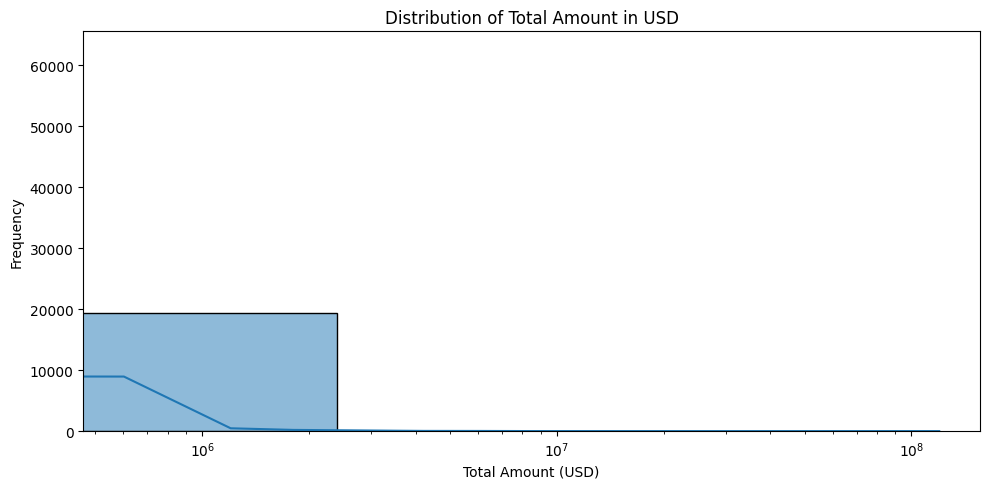

In [85]:
# Distribution of total USD amounts
plt.figure(figsize=(10, 5))
sns.histplot(df["total_amount_usd"], bins=50, kde=True)
plt.title("Distribution of Total Amount in USD")
plt.xlabel("Total Amount (USD)")
plt.ylabel("Frequency")
plt.xscale("log")  # log scale if skewed
plt.tight_layout()
plt.show()

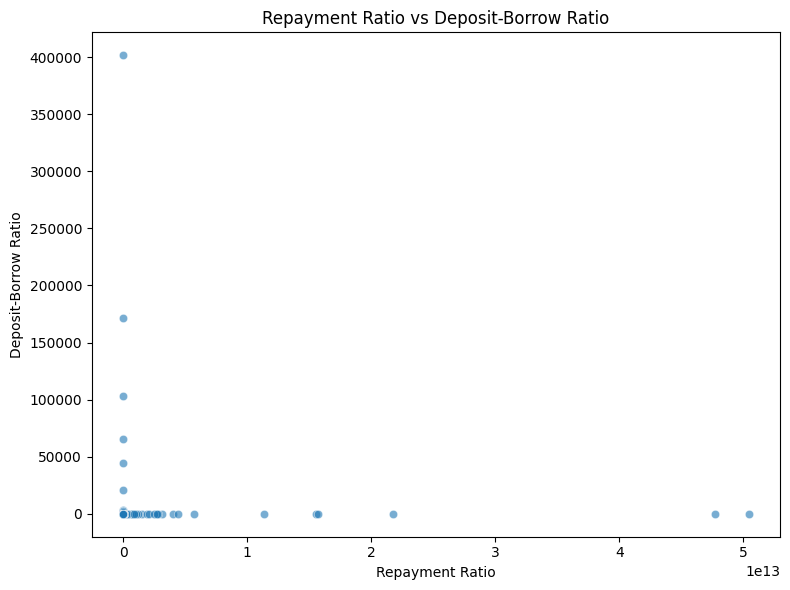

In [86]:
# Repayment Ratio vs Deposit-Borrow Ratio
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="repayment_ratio", y="deposit_borrow_ratio", alpha=0.6)
plt.title("Repayment Ratio vs Deposit-Borrow Ratio")
plt.xlabel("Repayment Ratio")
plt.ylabel("Deposit-Borrow Ratio")
plt.tight_layout()
plt.show()

In [31]:
df.columns

Index(['wallet_address', 'total_txns', 'total_amount_usd', 'num_unique_assets',
       'first_txn', 'last_txn', 'activity_days', 'borrows', 'deposits',
       'got_liquidated', 'liquidator', 'repays', 'withdraws', 'borrows_usd',
       'deposits_usd', 'got_liquidated_usd', 'liquidator_usd', 'repays_usd',
       'withdraws_usd', 'repayment_ratio', 'withdraw_deposit_ratio',
       'liquidation_borrow_ratio', 'liquidation_txn_ratio',
       'deposit_borrow_ratio', 'lifespan_days', 'active_days_ratio'],
      dtype='object')

In [32]:
df["num_txns"] = df["total_txns"]  # Assuming 'total_txns' represents the number of transactions
df["avg_txn_amount"] = df["total_amount_usd"] / df["total_txns"]
df["txn_frequency"] = df["total_txns"] / df["activity_days"]  # Transactions per active day

# Data Preprocessing and Feature Scaling for Clustering

This section performs several crucial steps to prepare the data for clustering analysis:

- **Feature Selection**:
  - A subset of relevant features is selected from the dataframe `df` for clustering analysis. These features represent key aspects of wallet behavior, such as transaction volume, repayment habits, and frequency of interaction with the protocol.
  - The selected features include `total_amount_usd`, `repayment_ratio`, `deposit_borrow_ratio`, `num_txns`, `avg_txn_amount`, and `txn_frequency`.

- **Handling Infinite and Large Values**:
  - The data is checked for any infinite values (both positive and negative). These values are replaced with NaN to ensure they do not interfere with the analysis. This step helps avoid distortion in the clustering results due to extreme values.

- **Missing Value Handling**:
  - Any rows containing NaN values are dropped from the dataset. This ensures that only complete and valid data points are used for clustering, maintaining the integrity of the analysis.

- **Feature Scaling**:
  - The selected features are scaled using **StandardScaler**. This is an essential step, as it standardizes the data by removing the mean and scaling to unit variance. Scaling ensures that all features contribute equally to the clustering process, preventing features with larger values from dominating the clustering algorithm.

- **Elbow Method for Optimal Clustering**:
  - The optimal number of clusters (`k`) for the KMeans algorithm is determined using the **Elbow Method**. This involves running KMeans clustering for values of `k` ranging from 1 to 10, and calculating the **inertia** (within-cluster sum of squared distances).
  - The inertia values are plotted to help identify the "elbow point," where the inertia begins to decrease more slowly. This point suggests the optimal number of clusters to be used for segmenting the wallets.
  - The plot helps visualize how the clustering performance changes with different numbers of clusters, guiding the choice of `k`.


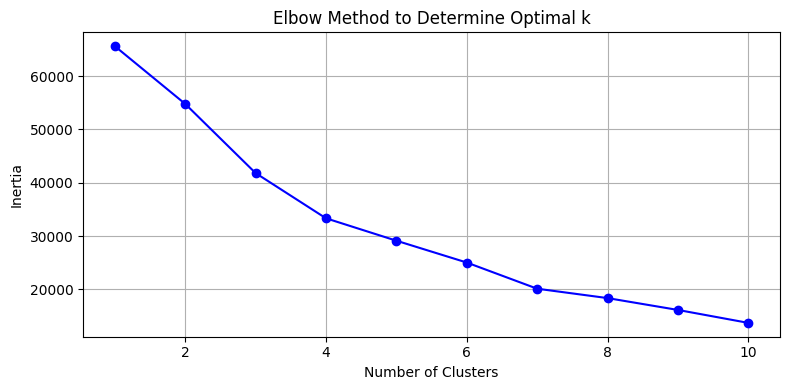

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select features
features = ["total_amount_usd", "repayment_ratio", "deposit_borrow_ratio", "num_txns", "avg_txn_amount", "txn_frequency"]
X = df[features].copy()


# Step 2: Replace infinite and large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
# X = X.clip(lower=-1e12, upper=1e12)  # Clip large values

# Step 3: Drop rows with NaN
X.dropna(inplace=True)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Step 5: Find optimal number of clusters using Elbow Method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
df_clean = df.loc[X.index].copy()

In [45]:
df.size,df_clean.size

(585750, 328050)

In [46]:
df=df_clean

# Clustering and Visualization of Wallet Behavior

In this section, we apply the KMeans clustering algorithm to segment the wallets based on their on-chain behavior, followed by a visualization of the clusters using Principal Component Analysis (PCA):

- **KMeans Clustering**:
  - We set the number of clusters (`optimal_k`) to 3 based on previous analysis with the Elbow Method.
  - The **KMeans** algorithm is then applied to the scaled data (`X_scaled`) to assign each wallet to one of the three clusters.
  - The cluster labels are stored in a new column `cluster` in the original dataframe (`df`), indicating which cluster each wallet belongs to.

- **PCA for Dimensionality Reduction**:
  - To visualize the high-dimensional clustered data, we reduce the number of features to two principal components using **Principal Component Analysis (PCA)**.
  - The PCA transforms the scaled data into two components (`pca1` and `pca2`), which are then added as new columns to the dataframe.

- **Visualization**:
  - A scatter plot is created using **Seaborn** to visualize the wallets in a 2D space defined by the two PCA components.
  - Each wallet is colored according to its assigned cluster, helping to visually differentiate between the behavior of the different wallet groups.
  - The plot displays the clustering of wallets based on their on-chain behavior, with each point representing a wallet, and the clusters indicated by different colors.


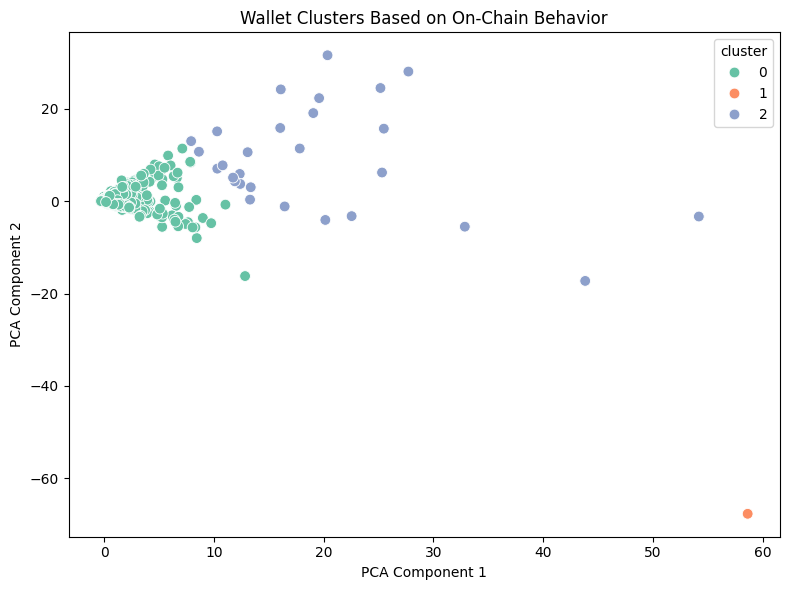

In [47]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

# Step 4: Visualize Clusters using PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df["pca1"] = components[:, 0]
df["pca2"] = components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="Set2", s=60)
plt.title("Wallet Clusters Based on On-Chain Behavior")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [48]:
cluster_profiles = df.groupby("cluster").mean(numeric_only=True)

print(cluster_profiles.T)

cluster                              0             1             2
total_txns                1.009059e+01  2.850000e+03  5.386071e+02
total_amount_usd          1.195269e+05  1.572932e+07  4.435727e+07
num_unique_assets         1.686044e+00  1.000000e+00  4.035714e+00
activity_days             1.293755e+02  2.640000e+02  2.267857e+02
borrows                   2.179351e+00  0.000000e+00  1.448929e+02
deposits                  2.231982e+00  0.000000e+00  5.385714e+01
got_liquidated            9.143591e-01  0.000000e+00  2.785714e+00
liquidator                4.501192e-01  0.000000e+00  2.038929e+02
repays                    2.013479e+00  2.850000e+03  1.000000e+02
withdraws                 2.301302e+00  0.000000e+00  3.317857e+01
borrows_usd               2.334515e+04  0.000000e+00  1.031446e+07
deposits_usd              1.596717e+04  0.000000e+00  2.987415e+06
got_liquidated_usd        1.573997e+04  0.000000e+00  7.761407e+06
liquidator_usd            1.573391e+04  0.000000e+00  1.021958

# Credit Score Assignment Based on Cluster and Repayment Behavior

In this section, we assign a credit score to each wallet based on its cluster and repayment behavior:

- **Score Ranges**:
  - We define three different score ranges based on the risk level associated with each cluster:
    - **Low Risk** (Cluster 0): Scores between 80 and 100
    - **Medium Risk** (Cluster 1): Scores between 50 and 79
    - **High Risk** (Cluster 2): Scores between 0 and 49

- **Credit Score Assignment**:
  - The function `assign_scores` groups the dataframe (`df`) by the cluster IDs and computes the **credit score** for each wallet.
  - For each cluster, the **minimum** and **maximum** values of the `repayment_ratio` within that cluster are calculated. These values are used to normalize the `repayment_ratio` of each wallet relative to the cluster's distribution.
  - The wallet's score is then determined by normalizing its `repayment_ratio` within the cluster’s range and mapping it to the corresponding score range defined earlier.

- **Normalization**:
  - If the difference between the maximum and minimum `repayment_ratio` within a cluster is zero (i.e., all wallets in that cluster have the same `repayment_ratio`), the wallet is assigned the average of the score range.
  - Otherwise, the wallet's `repayment_ratio` is normalized within the cluster, and the score is calculated based on the normalized value within the cluster's score range.

- **Result**:
  - The `credit_score` is then added as a new column to the dataframe (`df`), and the dataframe is returned with the assigned credit scores for each wallet.


In [49]:
def assign_scores(df):
    score_ranges = {
        0: (80, 100),  # Low risk/Good
        1: (50, 79),   # Medium risk/OK
        2: (0, 49),    # High risk/Bad
    }

    scores = []
    for cluster_id, group in df.groupby("cluster"):
        min_val = group["repayment_ratio"].min()
        max_val = group["repayment_ratio"].max()
        score_min, score_max = score_ranges[cluster_id]

        for _, row in group.iterrows():
            # Normalize repayment_ratio within the cluster
            if max_val - min_val == 0:
                score = (score_min + score_max) / 2
            else:
                normalized = (row["repayment_ratio"] - min_val) / (max_val - min_val)
                score = score_min + normalized * (score_max - score_min)
            scores.append(score)

    df["credit_score"] = scores
    return df

df = assign_scores(df)


In [51]:
df.head()

,wallet_address,total_txns,total_amount_usd,num_unique_assets,first_txn,last_txn,activity_days,borrows,deposits,got_liquidated,...,deposit_borrow_ratio,lifespan_days,active_days_ratio,num_txns,avg_txn_amount,txn_frequency,cluster,pca1,pca2,credit_score
0,0x0000000038355af6ffd5328a16cfd2170e59f39c,4,2224.528455,2,2023-11-15 20:11:59,2023-12-25 20:54:47,40,0,0,0,...,0.0,40.029722,0.999257,4,556.132114,0.100000,0,-0.267982,-0.004608,80.000000
1,0x000000005bcf85aad6ed1d32db5490deddfc97f9,22,10582.470939,6,2023-12-11 12:14:59,2024-07-29 02:57:35,230,0,0,0,...,0.0,230.612917,0.997342,22,481.021406,0.095652,0,-0.124201,-0.099615,80.000000
2,0x00000000af5a61acaf76190794e3fdf1289288a1,97,133020.456474,5,2019-08-14 17:21:40,2019-12-25 06:34:40,132,0,0,0,...,0.0,132.550694,0.995845,97,1371.344912,0.734848,0,0.725498,-0.710314,80.231612
3,0x00000000b1786c9698c160d78232c78d6f6474fe,30,29475.524013,5,2020-02-12 20:48:55,2020-06-02 14:59:25,110,0,0,0,...,0.0,110.757292,0.993163,30,982.517467,0.272727,0,0.037234,-0.253276,80.134588
4,0x0000000484f2217f1a64eb6d24b5cee446faeae5,17,438551.113244,1,2020-06-15 20:42:54,2020-06-22 16:46:12,6,9,0,0,...,0.0,6.835625,0.877754,17,25797.124308,2.833333,0,0.554990,-0.113115,80.000000


In [54]:
print(df['credit_score'].describe)

<bound method NDFrame.describe of 0        8.000000e+01
1        8.000000e+01
2        8.023161e+01
3        8.013459e+01
4        8.000000e+01
             ...     
19518    1.668398e-10
19520    0.000000e+00
19521    0.000000e+00
19523    8.416587e-11
19524    0.000000e+00
Name: credit_score, Length: 10935, dtype: float64>


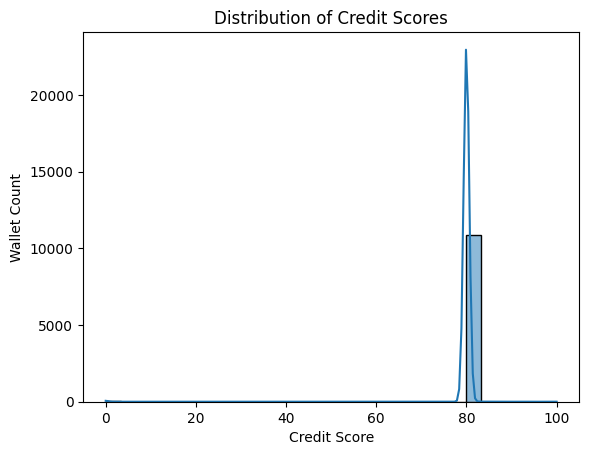

In [50]:
sns.histplot(df["credit_score"], bins=30, kde=True)
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.show()

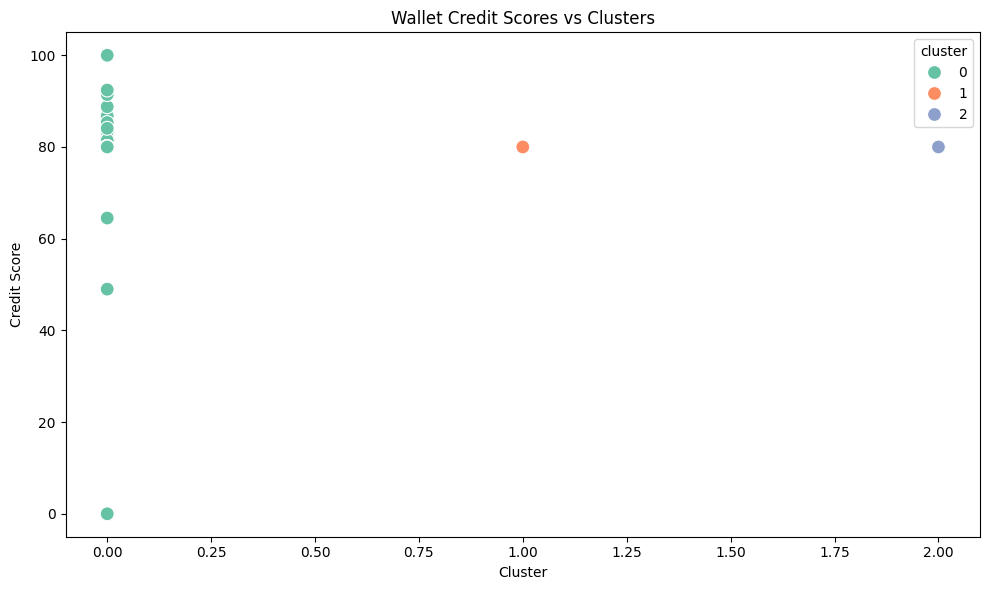

In [55]:
# Scatter plot to visualize clusters and their credit scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="cluster", y="credit_score", hue="cluster", palette="Set2", s=100)
plt.title("Wallet Credit Scores vs Clusters")
plt.xlabel("Cluster")
plt.ylabel("Credit Score")
plt.tight_layout()
plt.show()


<ipython-input-56-94d76b91653e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="credit_score", palette="Set2")


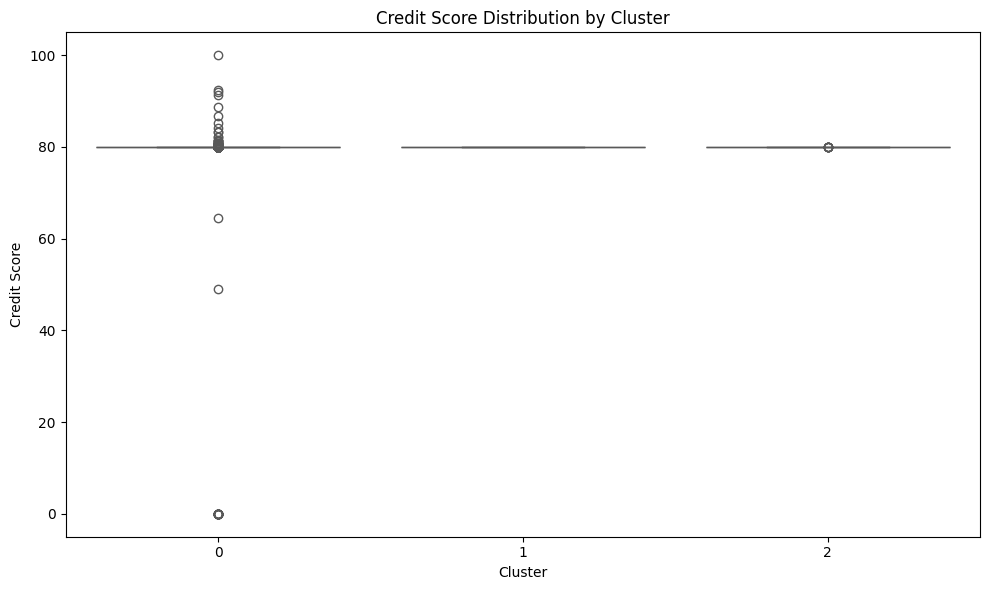

In [56]:
# Box plot to show distribution of credit scores across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="cluster", y="credit_score", palette="Set2")
plt.title("Credit Score Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Credit Score")
plt.tight_layout()
plt.show()


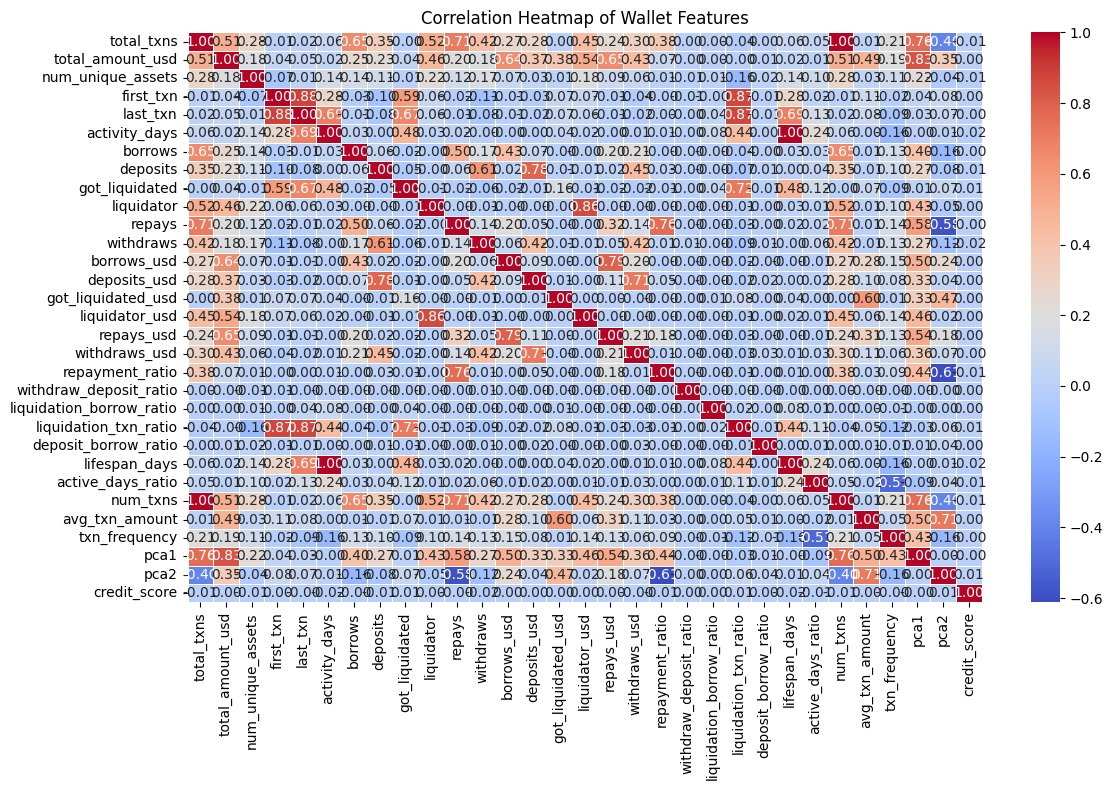

In [58]:
# Correlation heatmap
correlation_matrix = df.drop(columns=['wallet_address', 'cluster']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Wallet Features")
plt.tight_layout()
plt.show()


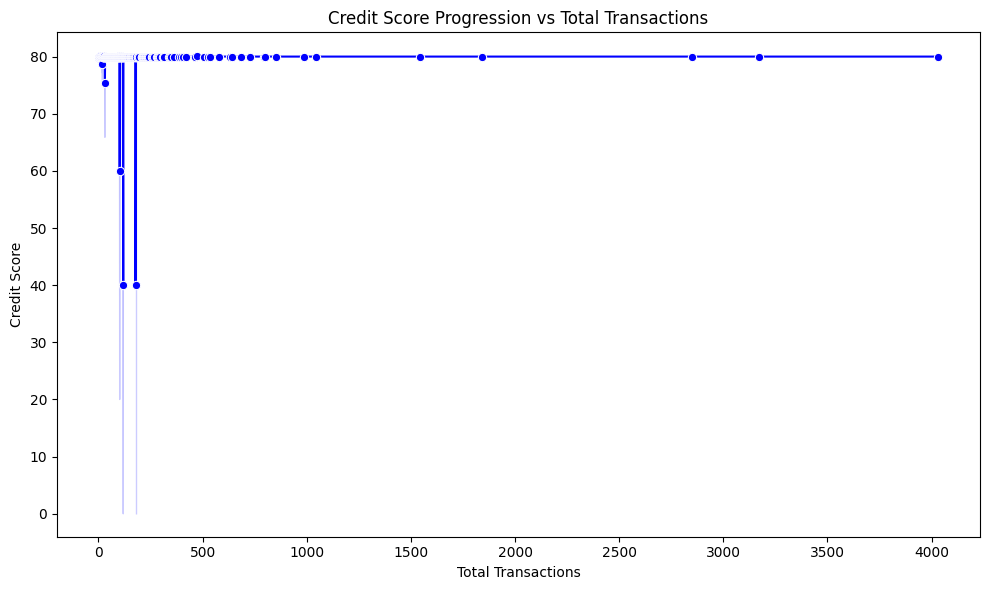

In [59]:
# Line plot for credit score progression by total number of transactions
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="total_txns", y="credit_score", marker="o", color="b")
plt.title("Credit Score Progression vs Total Transactions")
plt.xlabel("Total Transactions")
plt.ylabel("Credit Score")
plt.tight_layout()
plt.show()


# Cluster Quality Evaluation Using Silhouette Score

In this section, we evaluate the quality of the clustering performed by KMeans using the **Silhouette Score**:

- **Average Silhouette Score**:
  - The **silhouette score** is calculated for the entire dataset to evaluate the overall quality of the clustering. It ranges from -1 (poor clustering) to +1 (well-separated clusters), with scores close to 0 indicating overlapping clusters.
  - We use the `silhouette_score` function to compute the average silhouette score for the clustering result (`clusters`) and print it. This score helps assess how well the wallets are grouped into their respective clusters based on their on-chain behavior.

- **Silhouette Plot**:
  - To inspect the quality of each individual cluster, we generate a **silhouette plot**. This plot displays the silhouette values for each sample in the dataset, providing a visual representation of how well each sample fits into its assigned cluster.
  - For each cluster, the silhouette values are sorted and plotted as filled areas to visualize the range of silhouette values for the wallets in that cluster.
  - A red dashed vertical line represents the **average silhouette score**, allowing us to quickly assess if any clusters have poor cohesion or are poorly separated.
  - The silhouette plot helps us identify clusters with inconsistent or overlapping memberships, providing insight into the effectiveness of the clustering process.


Average silhouette score: 0.966


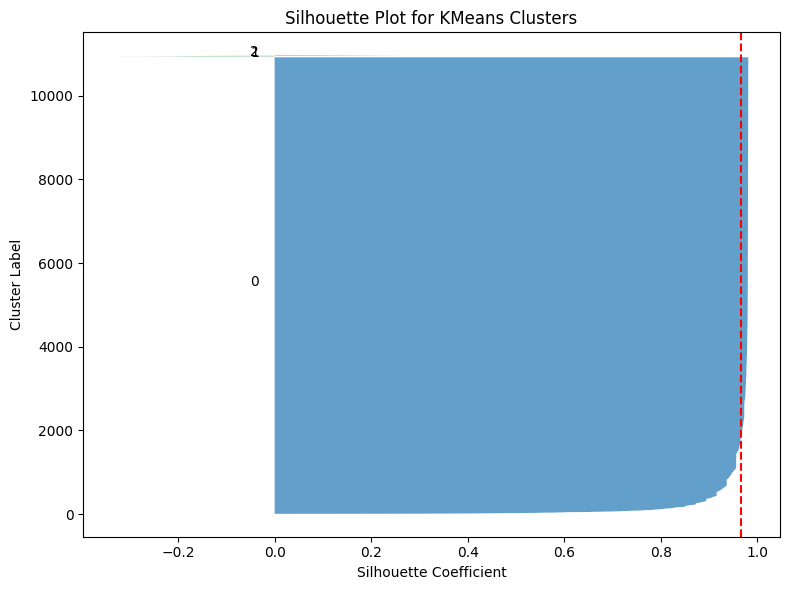

In [60]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# average silhouette score
avg_score = silhouette_score(X_scaled, clusters)
print(f"Average silhouette score: {avg_score:.3f}")

# Silhouette plot to inspect per-cluster quality
sample_silhouette_values = silhouette_samples(X_scaled, clusters)
y_lower = 10
n_clusters = optimal_k

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    ith_vals = sample_silhouette_values[clusters == i]
    ith_vals.sort()
    size_cluster = ith_vals.shape[0]
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for KMeans Clusters")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.axvline(x=avg_score, color="red", linestyle="--")
plt.tight_layout()
plt.show()


# Clustering Quality Evaluation Using Davies–Bouldin Index

In this section, we further evaluate the quality of the clustering using the **Davies-Bouldin index**:

- **Davies–Bouldin Index**:
  - The **Davies-Bouldin index** is another metric used to assess the quality of clustering. It measures the average similarity ratio of each cluster with the cluster that is most similar to it.
  - A lower Davies-Bouldin index indicates better clustering, where clusters are well-separated and compact. Conversely, a higher index suggests that clusters may overlap or are less distinct.
  - We calculate the Davies-Bouldin index using the `davies_bouldin_score` function, which compares the within-cluster scatter to the between-cluster separation for each cluster.
  - The calculated score is printed, providing an indication of the clustering's quality. A lower score indicates better-defined and more separated clusters.


In [61]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(X_scaled, clusters)
print(f"Davies–Bouldin index: {db_index:.3f}")


Davies–Bouldin index: 0.659


# Cluster Stability Evaluation

In this section, we assess the **stability** of the clustering results by running the KMeans algorithm multiple times on random subsets of the data:

- **Cluster Stability**:
  - The function `cluster_stability` is designed to evaluate how consistent the clustering is across multiple runs with different subsets of the dataset.
  - For each run, a random subset of the data (based on `sample_frac`, which is 80% by default) is selected, and KMeans is applied to cluster the data. The resulting cluster labels are then compared to the base labels (original clustering results) to measure how stable the assignments are for the samples in the subset.
  - If a sample is assigned to the same cluster in both the base and the new run, the stability score for that sample increases by 1.

- **Stability Score Calculation**:
  - The `stability` array is initialized with zeros, representing an initial stability score of 0 for each sample.
  - After performing `n_runs` (default 10) of random subsampling and clustering, the stability score for each sample is normalized by dividing by the total number of runs, resulting in a score between 0 and 1.
  - A higher score indicates that the sample is consistently assigned to the same cluster across multiple runs, suggesting that it belongs to a stable and well-defined cluster.

- **Average Stability**:
  - The average stability score across all samples is computed and printed, providing an overall measure of how stable the clustering results are. A higher average stability indicates that the clusters are robust and not sensitive to small changes in the data.


In [62]:
import numpy as np
from sklearn.cluster import KMeans

def cluster_stability(X, n_runs=10, sample_frac=0.8):
    base_labels = clusters
    n_samples = X.shape[0]
    stability = np.zeros(n_samples)

    for _ in range(n_runs):
        idx = np.random.choice(n_samples, size=int(sample_frac * n_samples), replace=False)
        km = KMeans(n_clusters=optimal_k, random_state=None)
        labels_sub = km.fit_predict(X[idx])
        # Map sub‑labels back to original indices
        for j, orig_idx in enumerate(idx):
            if base_labels[orig_idx] == labels_sub[j]:
                stability[orig_idx] += 1

    return stability / n_runs

stability_scores = cluster_stability(X_scaled)
print("Average stability:", stability_scores.mean())


Average stability: 0.5594695930498399


# Exporting Top 1000 Wallets Based on Credit Score

In this section, we assign scores to the wallets and save the top 1000 wallets with the highest scores to a CSV file:

- **Score Assignment**:
  - A new column called `score` is added to the dataframe (`df`). For simplicity, we are using the `credit_score` assigned earlier as the score. You can replace this with any custom scoring logic if needed, based on specific criteria (e.g., cluster label, repayment behavior, etc.).

- **Sorting and Selecting Top 1000 Wallets**:
  - The dataframe is sorted in descending order by the `score` column. This ensures that the wallets with the highest scores appear at the top.
  - The top 1000 wallets are selected using the `head(1000)` function, and only the `wallet_address` and `score` columns are retained for the output.

- **Saving to CSV**:
  - The selected top 1000 wallets are saved to a CSV file (`top_1000_wallets.csv`) for further analysis or reporting.
  - A confirmation message is printed to indicate that the file has been successfully saved.


In [69]:
df['score'] = df['credit_score']
# Descending order
top_1000_wallets = df[['wallet_address', 'score']].sort_values(by='score', ascending=False).head(1000)

# Saving into a CSV file
top_1000_wallets.to_csv('top_1000_wallets.csv', index=False)

print("CSV file for top 1000 wallets saved.")


CSV file for top 1000 wallets saved.
